<a href="https://colab.research.google.com/github/wuhyyy/TKAN-AE/blob/main/TKAN_AE_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jul 29 07:55:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!df -lh
print("============查看cpu配置================")
# 查看cpu配置
!cat /proc/cpuinfo | grep model\ name
print("=============查看内存容量===============")
# 查看内存容量
!cat /proc/meminfo | grep MemTotal
print("————————————————")

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   33G   46G  42% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1       106G   82G   25G  78% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
============查看cpu配置================
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
=============查看内存容量===============
MemTotal:       13290452 kB
————————————————


In [ ]:
!pip install gdown

#!pip install transformers
#!pip install tensorflow-gpu

^C


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
#from transformers import InformerConfig, InformerModel
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
!pip install tkan==0.2.0


In [ ]:
#!git clone https://github.com/remigenet/TKAN.git



In [ ]:

from tkan.spline import BSplineActivation, PowerSplineActivation, FixedSplineActivation
from tkan.tkan import TKAN

In [ ]:
!gdown --id 1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra --output spx.csv
#https://drive.google.com/file/d/1GDOPmkEaKAs_J_LVqEsUl05JNwGyOtq5/view?usp=drive_link
#https://drive.google.com/file/d/1PrxHkSQGBKoWJk4ec55gHC9-Mtj6s6ra/view?usp=drive_link

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:

#df = pd.read_csv('spx.csv')

In [ ]:
# prompt: 读取spx.csv中的内容，然后绘图，横坐标是time steps，纵坐标是pressure

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('spx.csv')

plt.plot(df['time steps'], df['pressure'])
plt.xlabel('Time Steps')
plt.ylabel('Pressure')
plt.title('Pressure vs. Time Steps')
plt.show()


In [ ]:
df.head()

In [ ]:
# prompt: 使用 DataFrame“df”: X轴是time steps，Y轴是pressure除以10后的值绘制一个图

import matplotlib.pyplot as plt

plt.plot(df["time steps"], df["pressure"]/10 )
plt.xlabel("Time Steps")
plt.ylabel("Pressure/KPa")
plt.grid(False)
plt.show()


In [ ]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
all_size = len(df)
train, test ,all= df.iloc[0:train_size], df.iloc[train_size:len(df)],df.iloc[0:len(df)],
print(train.shape, test.shape, all.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['pressure']])
scaler = scaler.fit(all[['pressure']])

train['pressure'] = scaler.transform(train[['pressure']])
test['pressure'] = scaler.transform(test[['pressure']])
all['pressure'] = scaler.transform(all[['pressure']])

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['pressure']], train.pressure, TIME_STEPS)
X_test, y_test = create_dataset(test[['pressure']], test.pressure, TIME_STEPS)
X_all, y_all = create_dataset(all[['pressure']], all.pressure, TIME_STEPS)
print(X_train.shape,X_test.shape,X_all.shape)


In [ ]:
'''
model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
      TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=True, use_bias=True),
      TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=False, use_bias=True),
      keras.layers.Dense(30),
])
model.compile(loss='mae', optimizer='adam')
'''

In [ ]:
# prompt: model = tf.keras.Sequential([
#       tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
#       TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=True, use_bias=True),
#       TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=False, use_bias=True),
#       keras.layers.Dense(30),
# ])
# model.compile(loss='mae', optimizer='adam')
# 在将这个模型嵌入到autoencoder框架中

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Define the encoder model
encoder_model = Sequential([
    Input(shape=X_train.shape[1:]),
    #TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=True, use_bias=True),
    #tf.keras.layers.Dropout(rate=0.2),
    TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=False, use_bias=True),
    #tf.keras.layers.Dropout(rate=0.2),
    Dense(30)
])

# Define the decoder model
# Define the decoder model
decoder_model = Sequential([
    Input(shape=(30,)),
    RepeatVector(TIME_STEPS),  # Repeats the input to create a time dimension
    #TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=True, use_bias=True),
    #tf.keras.layers.Dropout(rate=0.2),
    TKAN(100, tkan_activations=[BSplineActivation(3)], return_sequences=True, use_bias=True),
    #tf.keras.layers.Dropout(rate=0.2),# Keep return_sequences=True
    TimeDistributed(Dense(1))  # Now operates on each time step of the 3D input
])
# Define the autoencoder model
autoencoder_model = Sequential([
    encoder_model,
    decoder_model

])
model=autoencoder_model
# Compile the autoencoder model
model.compile(loss='mae', optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
import tensorflow as tf

# Build the model by specifying the input shape
model.build((None, X_train.shape[1], X_train.shape[2]))

total_params = model.count_params()
print(f"Total parameters: {total_params}")

Total parameters: 73544


In [ ]:
# prompt: 计算训练所用的时间

import time

start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    shuffle=False
)

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time:.4f} seconds")


In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)
#X_train_pred = tf.expand_dims(X_train_pred, axis=-1)
print(X_train_pred.shape)
print(X_train.shape)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)
#X_test_pred = tf.expand_dims(X_test_pred, axis=-1)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
X_all_pred = model.predict(X_all)
#X_all_pred = tf.expand_dims(X_all_pred, axis=-1)
mae_loss = np.mean(np.abs(X_all_pred- X_all), axis=1)

In [ ]:
THRESHOLD =1.3

all_score_df = pd.DataFrame(index=all[TIME_STEPS:].index)
all_score_df['loss'] = mae_loss
all_score_df['threshold'] = THRESHOLD
all_score_df['anomaly'] = all_score_df.loss > all_score_df.threshold
all_score_df['pressure'] = all[TIME_STEPS:].pressure

In [ ]:
anomalies = all_score_df[all_score_df.anomaly == True]
anomalies.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经定义了变量 'test', 'anomalies', 和 'scaler'

# 重塑数据前修改这部分
pressure_prices_all = scaler.inverse_transform(all[TIME_STEPS:].pressure.values.reshape(1, -1)).reshape(-1) / 10
pressure_prices_anomalies = scaler.inverse_transform(anomalies.pressure.values.reshape(1, -1)).reshape(-1) / 10

# 创建图形和坐标轴
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
#ax1.set_title('GRU-AE Example Demonstration of Traditional Reconstruction Error Anomaly Detection Based on Threshold', fontsize=14)

# 第一个图：压力价格与异常值, 使用 matplotlib 的 scatter 方法
ax2.plot(
  all[TIME_STEPS:].index,
  pressure_prices_all,
  label='Pressure'
)
ax2.scatter(
  anomalies.index,
  pressure_prices_anomalies,
  color='red',  # 使用红色标记异常点
  s=52,         # 设置点的大小
  label='Anomaly'
)
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([int(x) for x in ax2.get_xticks()], rotation=25)
ax2.legend()
ax2.set_ylabel('Pressure/KPa')

# 第二个图：损失和阈值随时间变化
ax1.plot(
  all_score_df.index,
  all_score_df.loss,
  label='Loss'
)
ax1.plot(
  all_score_df.index,
  all_score_df.threshold,
  label='Threshold'
)
ax1.set_xticklabels([int(x) for x in ax1.get_xticks()], rotation=25)
ax1.legend()
ax1.set_ylabel('Loss')
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()  # 调整布局以防重叠
plt.show()


In [ ]:
anomalies = all_score_df[all_score_df.anomaly == True]
anomalies.head()

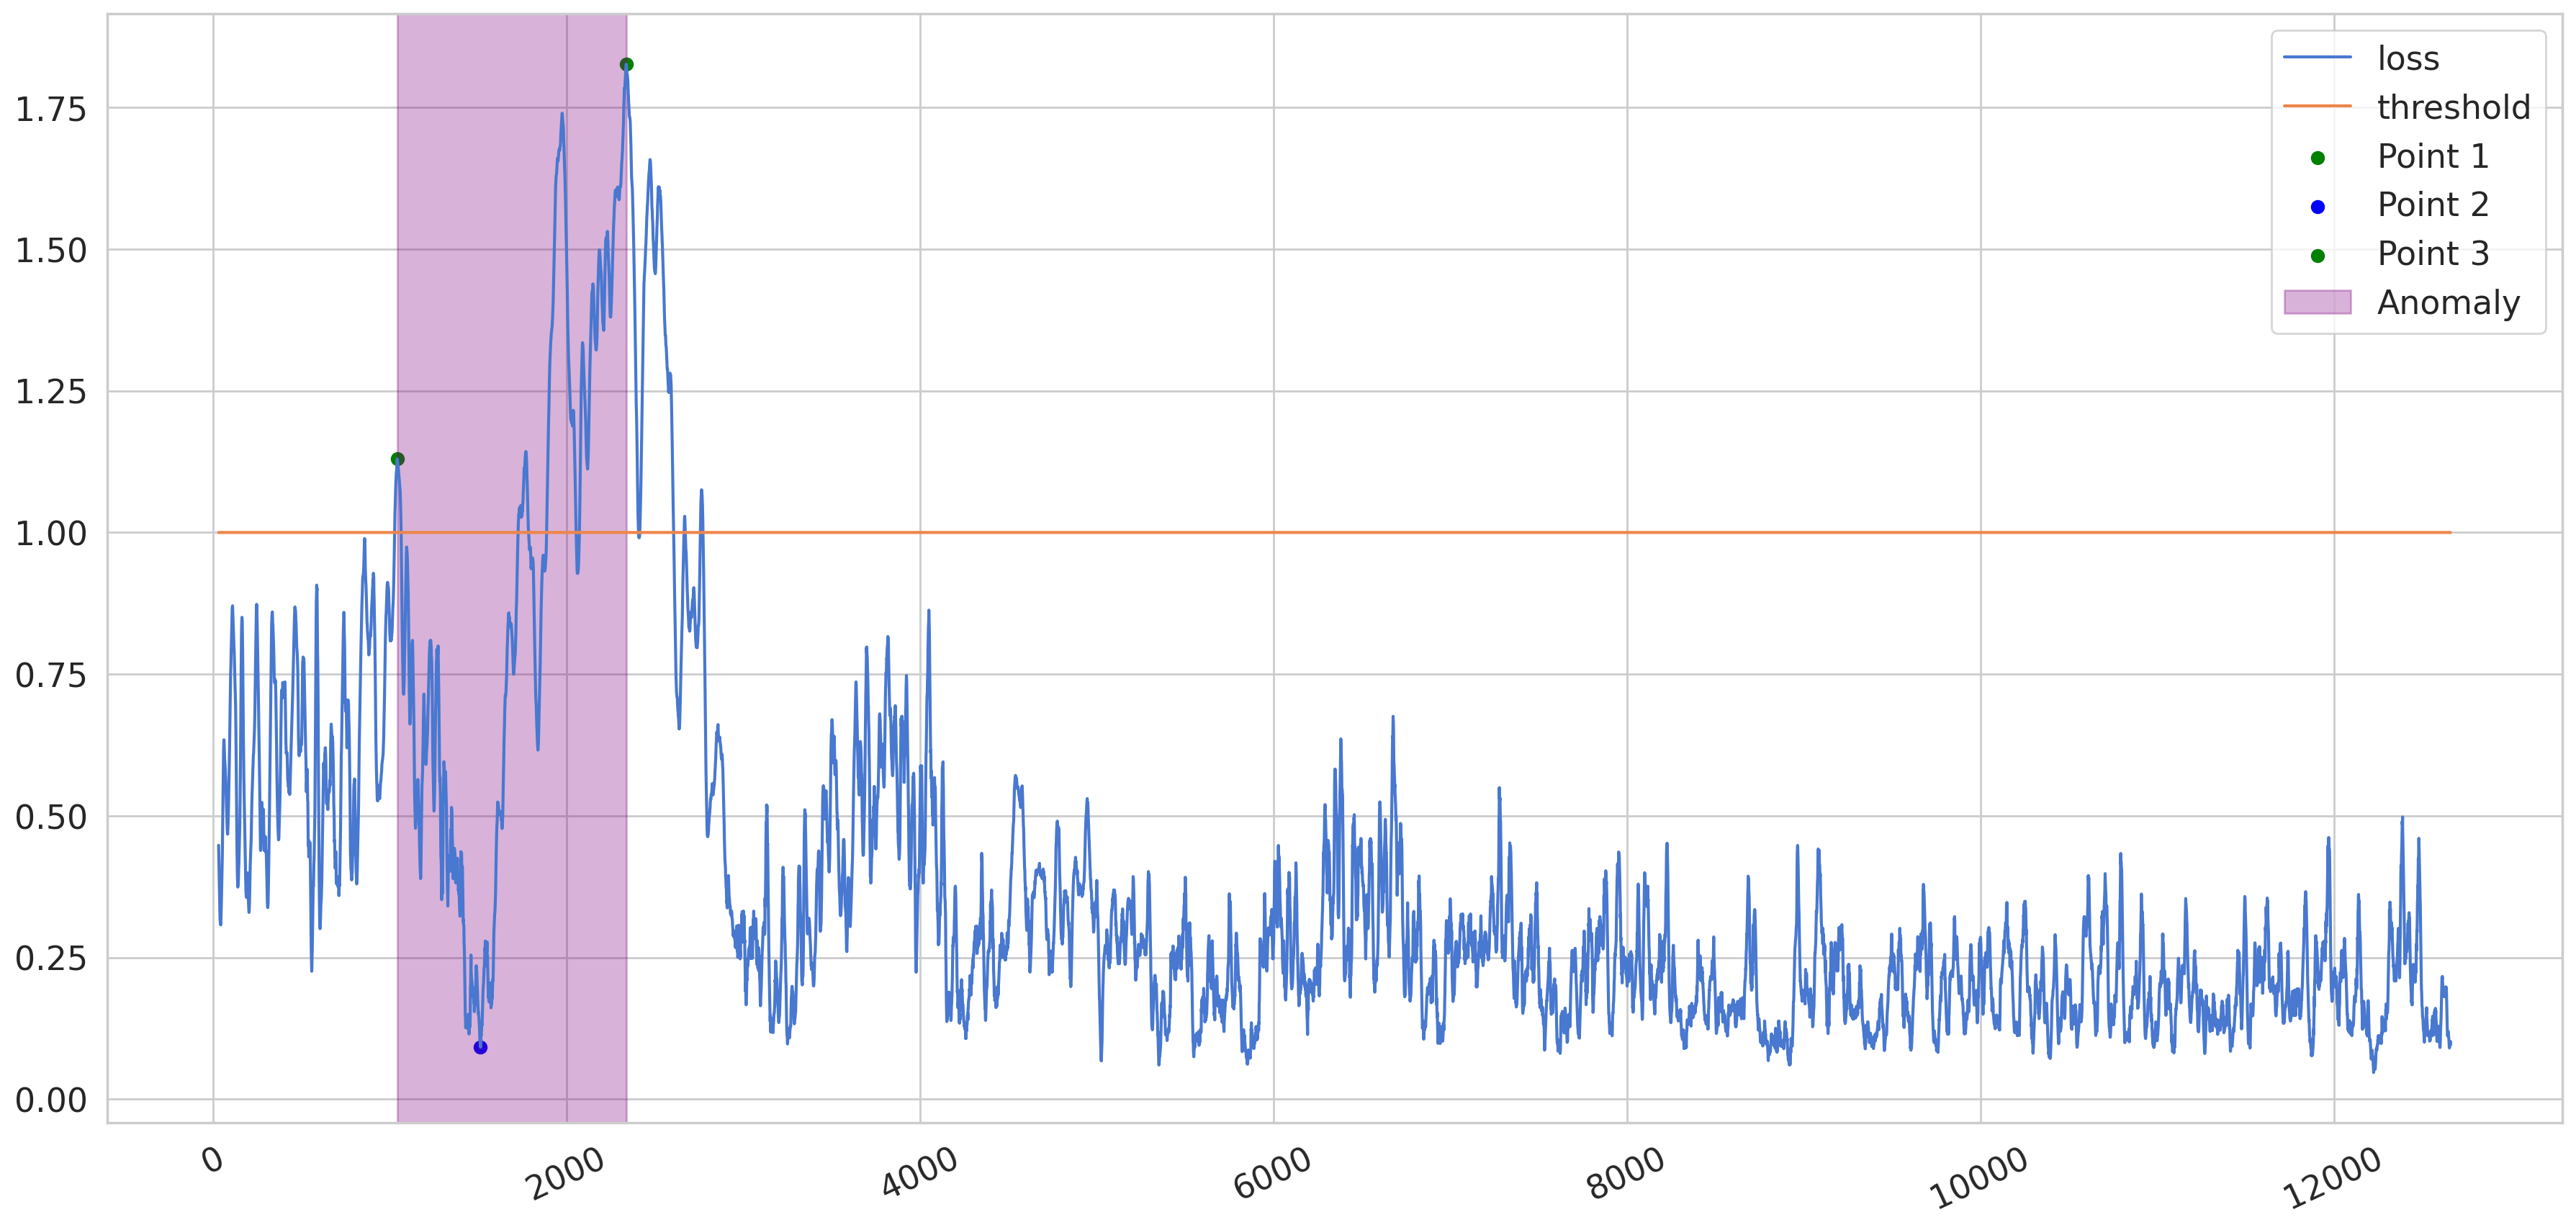

In [ ]:

import matplotlib.pyplot as plt
# Find the index of the point with the maximum loss
max_loss_index = all_score_df['loss'].idxmax()

# Find the index of the point with the minimum loss before the maximum loss point
min_loss_index_before_max = all_score_df.loc[:max_loss_index]['loss'].idxmin()

# Find the index of the point with the maximum loss **before** the minimum loss point
# Search from the beginning of the DataFrame up to Point 2
max_loss_index_before_min = all_score_df.loc[:min_loss_index_before_max]['loss'].idxmax()

# Plot the points
plt.plot(all_score_df.index, all_score_df.loss, label='loss')
plt.plot(all_score_df.index, all_score_df.threshold, label='threshold')
plt.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
plt.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
plt.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')

# Plot the points between point 1 and point 3
plt.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
plt.grid(False)
plt.xticks(rotation=25)
plt.legend();


In [ ]:
import matplotlib.pyplot as plt

# ... (previous code to calculate indices remains the same)

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot loss and threshold on the first axis
ax1.plot(all_score_df.index, all_score_df.loss, label='loss')
ax1.grid(False)
ax1.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'loss'], color='green', label='Point 1')
ax1.scatter(min_loss_index_before_max, all_score_df.loc[min_loss_index_before_max, 'loss'], color='blue', label='Point 2')
ax1.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'loss'], color='green', label='Point 3')
ax1.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax1.set_ylabel('Loss')
plt.grid(False)
ax1.legend(loc='upper right')

# Plot pressure on the second axis
ax2.plot(all_score_df.index, all_score_df.pressure, label='pressure')
ax2.scatter(max_loss_index, all_score_df.loc[max_loss_index, 'pressure'], color='green', label='Point 1')
ax2.scatter(max_loss_index_before_min, all_score_df.loc[max_loss_index_before_min, 'pressure'], color='green', label='Point 3')
ax2.axvspan(max_loss_index_before_min, max_loss_index, color='purple', alpha=0.3, label='Anomaly')
ax2.set_ylabel('Pressure')
ax2.legend(loc='upper right')
plt.grid(False)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've already defined the variables 'test', 'anomalies', and 'scaler'

# Modify this part to reshape the data before applying inverse_transform
pressure_prices_all = scaler.inverse_transform(all[TIME_STEPS:].pressure.values.reshape(1, -1)).reshape(-1)
pressure_prices_anomalies = scaler.inverse_transform(anomalies.pressure.values.reshape(1, -1)).reshape(-1)

plt.plot(
  all[TIME_STEPS:].index,
  pressure_prices_all,
  label='Pressure signal'
)

sns.scatterplot(
  x=anomalies.index,  # Specify x data
  y=pressure_prices_anomalies,  # Specify y data
  color=sns.color_palette()[3],
  s=52,
  label='anomaly point'
)
plt.xlabel("Time Steps")
plt.ylabel("Pressure/KPa")
plt.xticks(rotation=25)
plt.legend()
plt.grid(False)
plt.show()